In [1]:
import sys
sys.path.append('../1.load')

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from plot_utils import plot_mean_feature_per_well

from preprocess import preprocess_profiles


In [2]:
figsave_path = "output/plate_visualizations"

# features = ["Cells_AreaShape_Area", "Cells_Intensity_MeanIntensity_AGP", "Image_Threshold_SumOfEntropies_CellsIncludingEdges"]
features = ["Cells_Count"]

feature_select_ops = {"operation": "blocklist", "image_features": True}

In [3]:
# profiles = pd.read_parquet("output/subset_profiles_cc_well_corrected.parquet")

profiles = {
    "raw_profiles":  "../1.load/output/raw_filtered_profiles.parquet",
    "cc_adj_profiles": "../3.correct/output/profiles_cc_adjusted.parquet",
    "well_mean_subtracted": "../3.correct/output/full_profiles_mean_corrected.parquet",
    "cc_adj_well_mean_subtracted": "../3.correct/output/full_profiles_cc_adj_mean_corr.parquet"
}

# profiles = pd.read_parquet("output/subset_profiles_cc_corrected.parquet")
# profiles

raw_profiles Cells_Count correlation with Cells_Count: 1.0


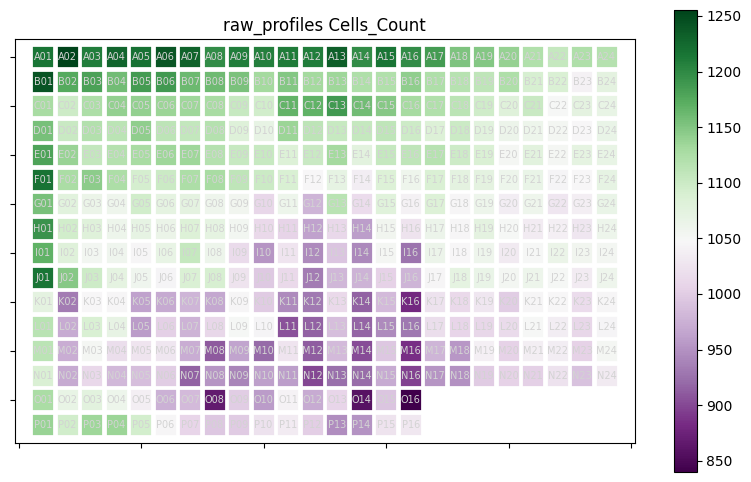

cc_adj_profiles Cells_Count correlation with Cells_Count: 1.0


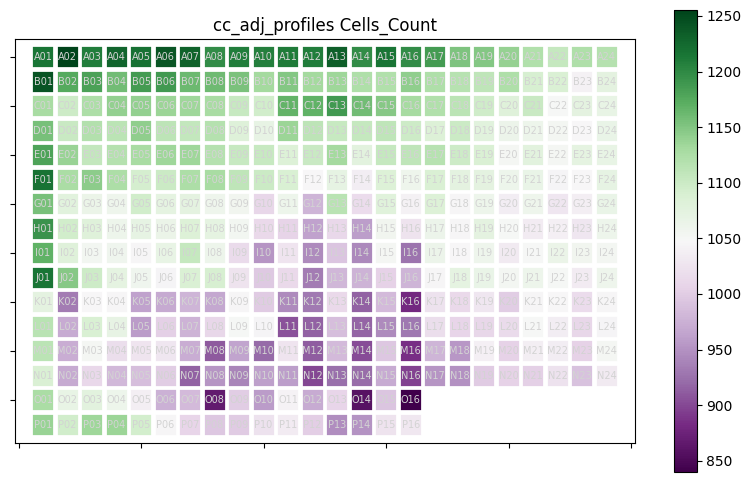

well_mean_subtracted Cells_Count correlation with Cells_Count: 1.0


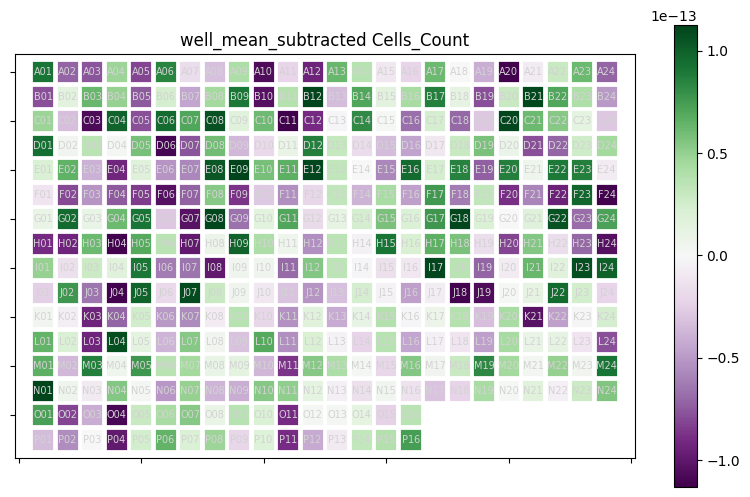

cc_adj_well_mean_subtracted Cells_Count correlation with Cells_Count: 1.0


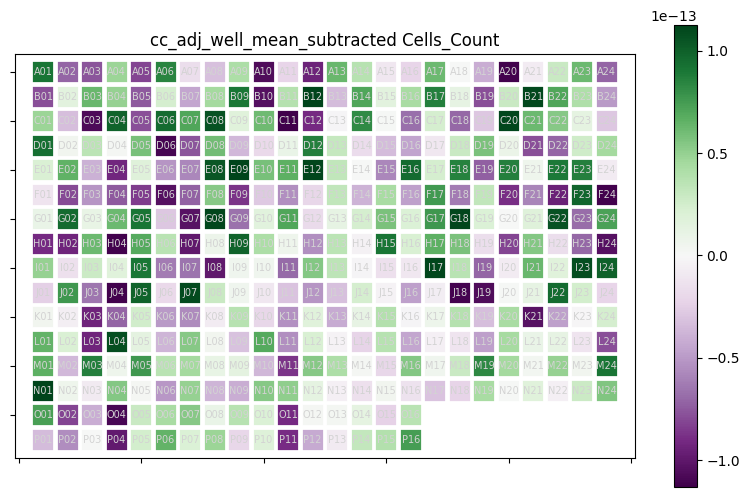

In [4]:
for p in profiles:
    df = pd.read_parquet(profiles[p])

    # df = preprocess_profiles(df, feature_select_kwargs=feature_select_ops)

    for feature in features:
        print(f"{p} {feature} correlation with Cells_Count: {df[feature].corr(df['Cells_Count'])}")
        plot_mean_feature_per_well(df, feature, prefix=p, figsave_path=figsave_path)
        plt.show()